# Solver Run Time Comparison
***
## Setup the Environment
***

In [1]:
import os
import sys
sys.path.insert(1, os.path.abspath(os.path.join(os.getcwd(), '../../GillesPy2/')))

MatPlotLib is used for creating custom visualizations

In [2]:
import matplotlib.pyplot as plt

In [3]:
import time

In [4]:
import gillespy2

***
## Create the Simple Hybrid Model
***

In [5]:
def create_birth_death_model( initial_value=1 ):
    # Initialize Model
    model = gillespy2.Model(name="Birth-Death")

    # Define Variables (GillesPy2.Species)
    A = gillespy2.Species(name='A', initial_value = initial_value )
    V = gillespy2.Species(name='V', initial_value = initial_value ) # used as a constant scaling factor

    # Add Variables to Model
    model.add_species([A, V])

    # Define Parameters
    rate1 = gillespy2.Parameter(name='rate1', expression= 10.0)
    rate2 = gillespy2.Parameter(name='rate2', expression= 10.0)
    
    # Add Parameters to Model
    model.add_parameter([rate1, rate2])

    # Define Reactions
    r1 = gillespy2.Reaction(name="r1", reactants={}, products={'A': 1}, propensity_function="rate1 * V")
    r2 = gillespy2.Reaction(name="r2", reactants={'A': 1}, products={}, rate='rate2')

    # Add Reactions to Model
    model.add_reaction([r1, r2])
    
    # Define Timespan
    tspan = gillespy2.TimeSpan.linspace(t=100, num_points=101)
    
    # Set Model Timespan
    model.timespan(tspan)
    return model

***
## Run the Simulations
***
### Time Comparison Test Method

In [6]:
all_solvers = {}
for s in dir(gillespy2.solvers):
    if s.endswith('Solver'):
        #print(s)
        all_solvers[s]=eval('gillespy2.solvers.'+s)
all_solvers

{'CLESolver': gillespy2.solvers.numpy.CLE_solver.CLESolver,
 'NumPySSASolver': gillespy2.solvers.numpy.ssa_solver.NumPySSASolver,
 'ODECSolver': gillespy2.solvers.cpp.ode_c_solver.ODECSolver,
 'ODESolver': gillespy2.solvers.numpy.ode_solver.ODESolver,
 'SSACSolver': gillespy2.solvers.cpp.ssa_c_solver.SSACSolver,
 'TauHybridCSolver': gillespy2.solvers.cpp.tau_hybrid_c_solver.TauHybridCSolver,
 'TauHybridSolver': gillespy2.solvers.numpy.tau_hybrid_solver.TauHybridSolver,
 'TauLeapingCSolver': gillespy2.solvers.cpp.tau_leaping_c_solver.TauLeapingCSolver,
 'TauLeapingSolver': gillespy2.solvers.numpy.tau_leaping_solver.TauLeapingSolver,
 'VariableSSACSolver': gillespy2.solvers.cpp.variable_ssa_c_solver.VariableSSACSolver}

In [7]:
Solver_plot_order = ['SSA','TauHybrid','TauLeaping','ODE']

In [8]:
C_solvers = {
 'ODE': gillespy2.solvers.cpp.ode_c_solver.ODECSolver,
 'SSA': gillespy2.solvers.cpp.ssa_c_solver.SSACSolver,
 'TauHybrid': gillespy2.solvers.cpp.tau_hybrid_c_solver.TauHybridCSolver,
 'TauLeaping': gillespy2.solvers.cpp.tau_leaping_c_solver.TauLeapingCSolver}

In [9]:
NumPy_solvers = {
 'SSA': gillespy2.solvers.numpy.ssa_solver.NumPySSASolver,
 'ODE': gillespy2.solvers.numpy.ode_solver.ODESolver,
 'TauHybrid': gillespy2.solvers.numpy.tau_hybrid_solver.TauHybridSolver,
 'TauLeaping': gillespy2.solvers.numpy.tau_leaping_solver.TauLeapingSolver
}

In [10]:
def run_test(solverClass, max_time=0.5):
    import inspect
    if 'variable' in inspect.signature(solverClass).parameters.keys():
        model = create_birth_death_model()
        solver = solverClass(model=model, variable=True)
        run_times = []
        for val in v_range:
            time_start = time.perf_counter()
            model.run(solver=solver, variables={"V": val,"A": val})
            time_end = time.perf_counter()
            run_times.append(time_end - time_start)
            if (time_end - time_start) > max_time:
                break
        return run_times
    else:
        run_times = []
        for val in v_range:
            model = create_birth_death_model(val)
            solver = solverClass(model=model)
            time_start = time.perf_counter()
            model.run(solver=solver)
            time_end = time.perf_counter()
            run_times.append(time_end - time_start)
            if (time_end - time_start) > max_time:
                break
        return run_times
        

In [11]:
def run_all_test(solver_list, max_time=0.5):
    timing_data = {}
    for name,solver in solver_list.items():
        print(name, end=' ')
        try:
            time_start = time.perf_counter()
            timing_data[name] = run_test(solver, max_time=max_time)
            time_end = time.perf_counter()
            print(len(timing_data[name]), end=' ')
            print(str(time_end - time_start)+'s')
        except Exception as e:
            print("Caught: "+str(e))
    return timing_data

# C++ Solvers

In [12]:
v_range = range(1, 3000, 20)

In [13]:
%time C_solver_timing_data = run_all_test(C_solvers)

ODE 150 11.459988877002615s
SSA 150 31.23522765999951s
TauHybrid 150 34.66282927500288s
TauLeaping 150 15.83536579900101s
CPU times: user 1.22 s, sys: 1.44 s, total: 2.66 s
Wall time: 1min 33s


In [14]:
C_solver_timing_data

{'ODE': [0.007935278998047579,
  0.007290501998795662,
  0.008783077995758504,
  0.007069748004141729,
  0.009268612993764691,
  0.007265583997650538,
  0.008400475999224,
  0.006931135998456739,
  0.008685301996592898,
  0.007022566001978703,
  0.00804935199994361,
  0.007128493998607155,
  0.007708469005592633,
  0.008777344002737664,
  0.011519184998178389,
  0.011329436005325988,
  0.011041416000807658,
  0.010683237997000106,
  0.008020203000342008,
  0.010200988996075466,
  0.007376371999271214,
  0.008864319002896082,
  0.007008991997281555,
  0.008223593002185225,
  0.006976035998377483,
  0.007731344005151186,
  0.007547988003352657,
  0.009835324002779089,
  0.00722339800267946,
  0.008246466997661628,
  0.007783039000059944,
  0.008593862999987323,
  0.007763864996377379,
  0.008320712004206143,
  0.008539089001715183,
  0.008686916997248773,
  0.008146972999384161,
  0.008502815995598212,
  0.008311858000524808,
  0.009289050998631865,
  0.007698315996094607,
  0.0092274080

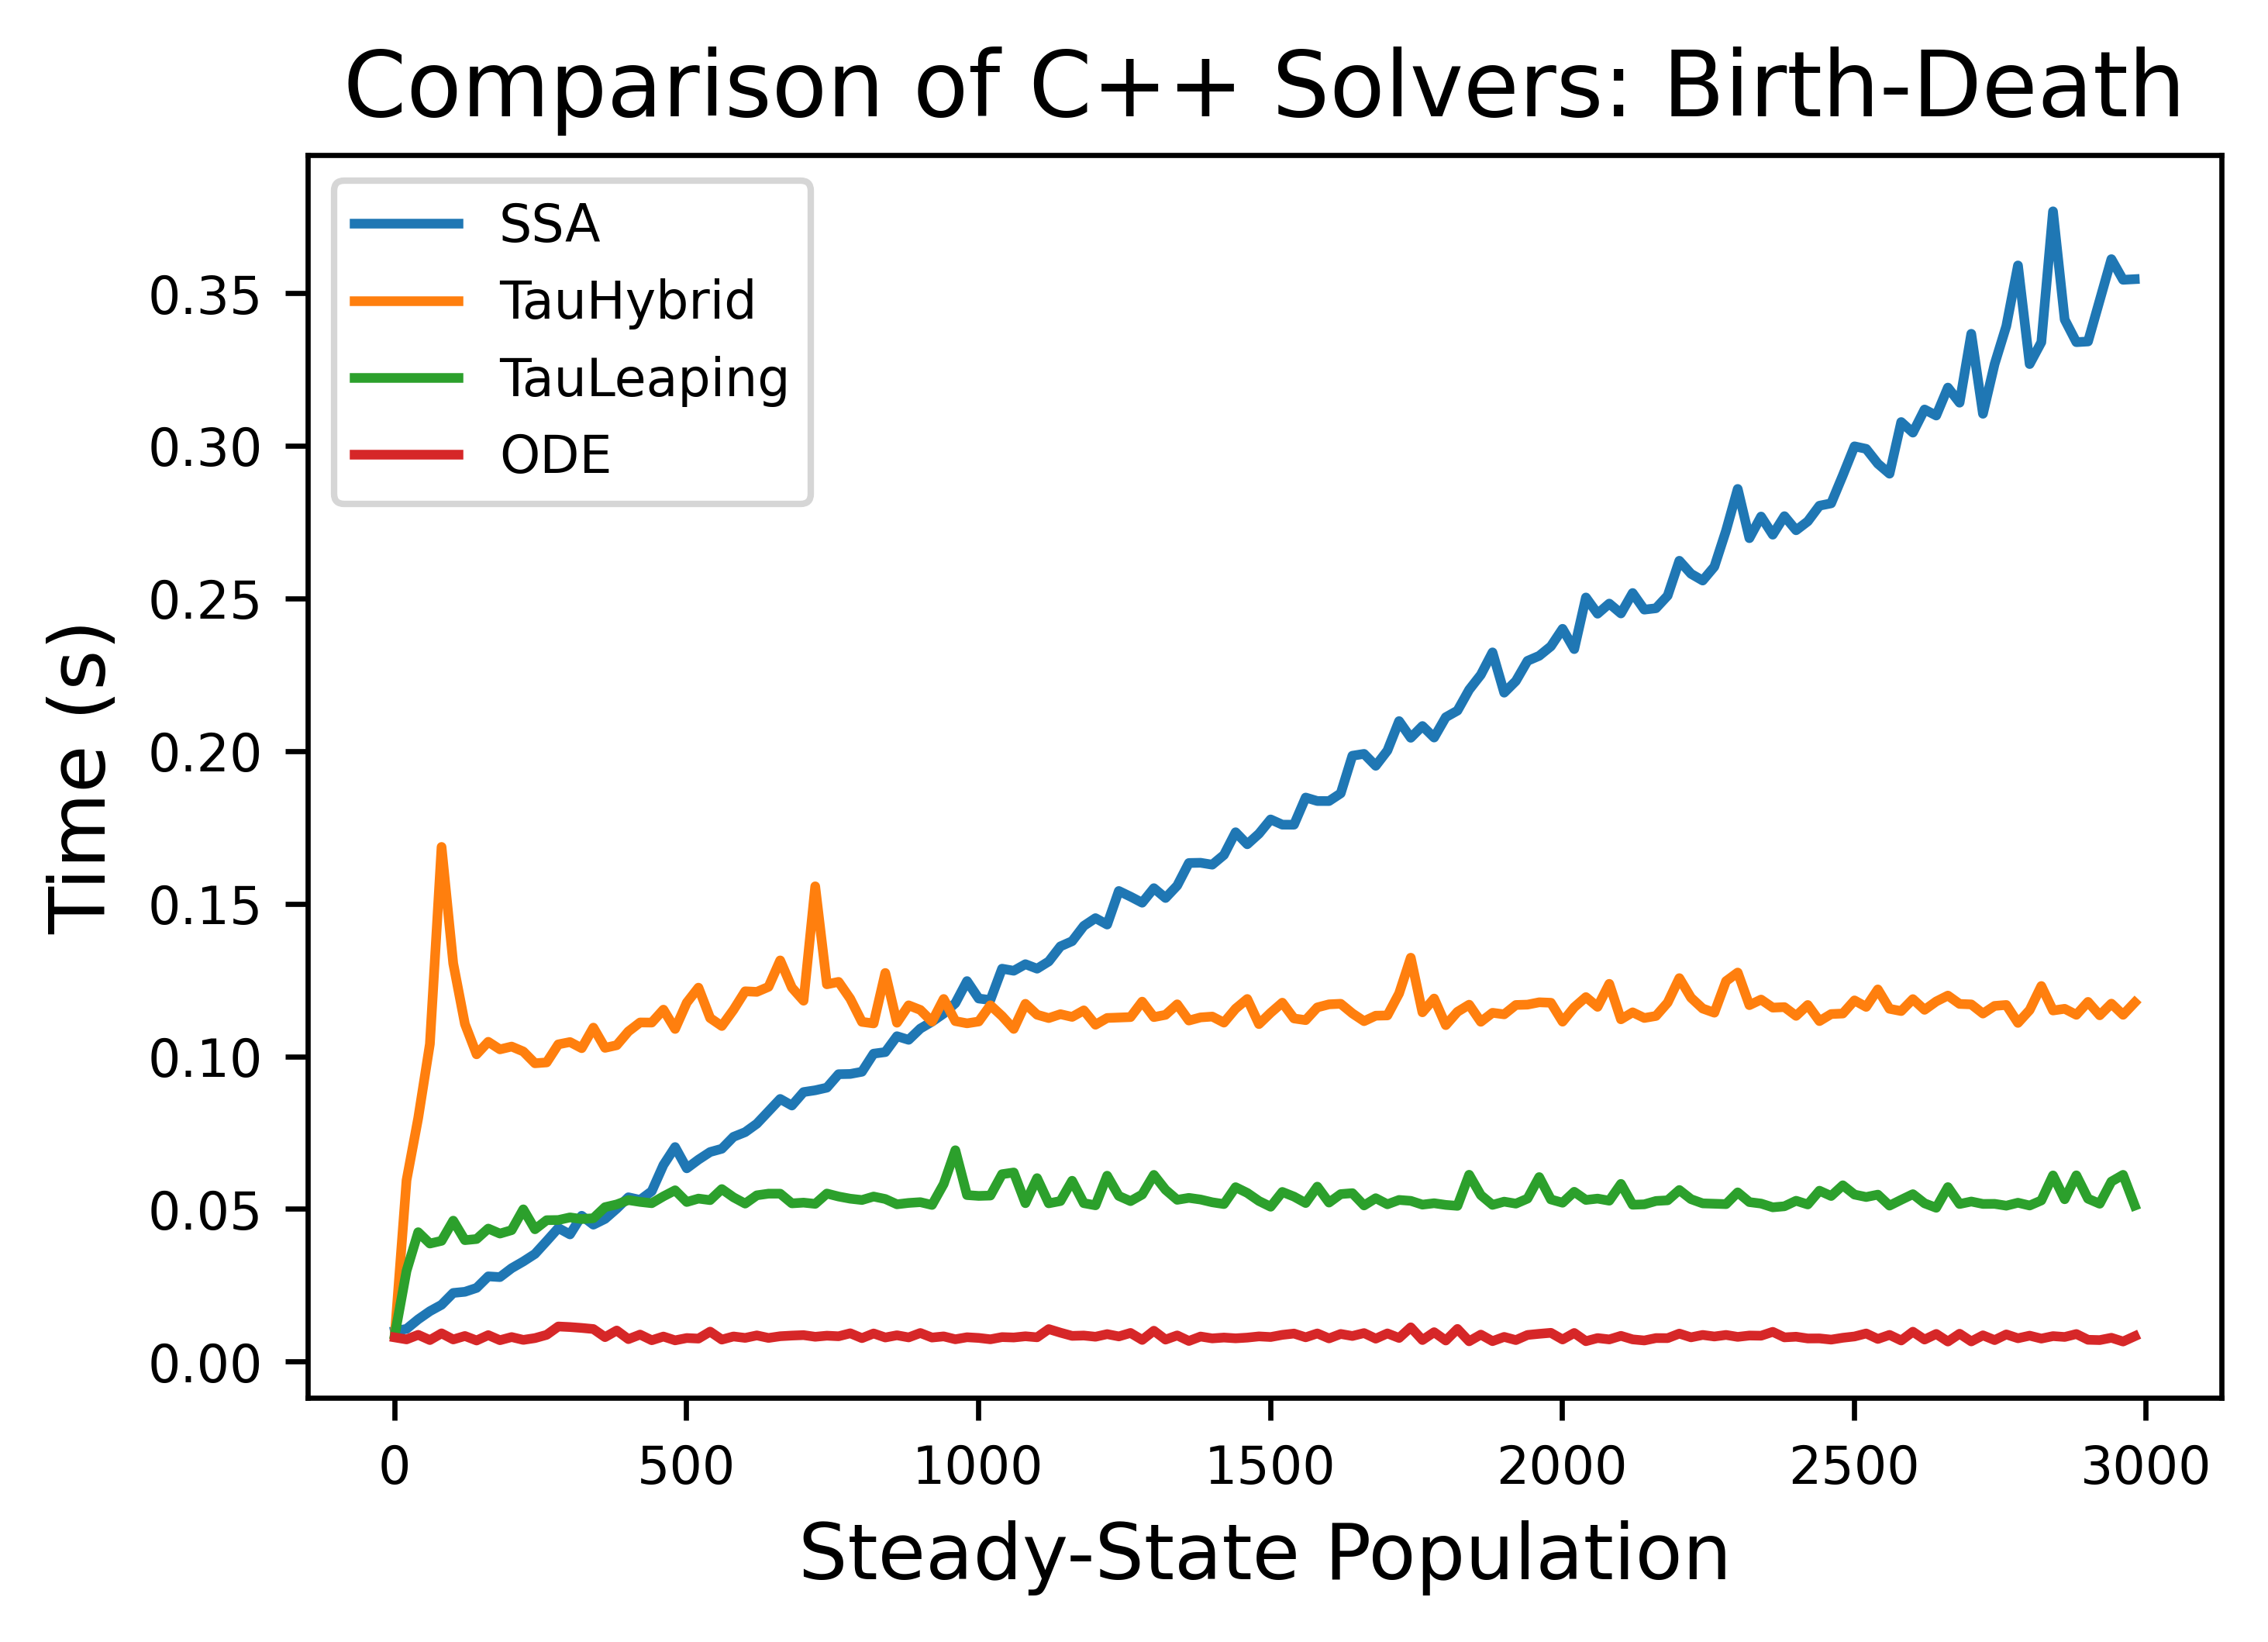

In [15]:
#fig = plt.figure(figsize=(3.54,3.54), dpi=600)
fig = plt.figure(figsize=(5.31,3.54), dpi=600)
#for name,times in C_solver_timing_data.items():
for name in Solver_plot_order:
    times = C_solver_timing_data[name]
    name2=name.replace('CSolver','')
    try:
        plt.plot(v_range[0:len(C_solver_timing_data[name])], C_solver_timing_data[name], label=name2)
    except Exception as e:
        print(name)
        raise e
plt.title("Comparison of C++ Solvers: Birth-Death", fontsize=14)
plt.xlabel('Steady-State Population', fontsize=12)
plt.ylabel('Time (s)', fontsize=12)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(loc='best', fontsize=8)
plt.savefig('../images/Time_Comparison_Of_Solvers.pdf', bbox_inches='tight')

# Numpy Solvers

In [16]:
v_range = range(1, 50, 1)

In [17]:
%time NumPy_solvers_timing_data = run_all_test(NumPy_solvers, max_time=4)

SSA 49 34.98116314099752s
ODE 49 0.12756277299922658s
TauHybrid 9 21.5822570119999s
TauLeaping 49 23.557340713996382s
CPU times: user 1min 20s, sys: 106 ms, total: 1min 20s
Wall time: 1min 20s


In [18]:
NumPy_solvers_timing_data.items()

dict_items([('SSA', [0.036497834997135215, 0.05777571499493206, 0.08183943900075974, 0.11541238200152293, 0.13465799199911999, 0.17598757200175896, 0.1919273380044615, 0.23776076899957843, 0.240514475000964, 0.2712691039996571, 0.3180525200004922, 0.34636839700397104, 0.35049355599767296, 0.3763120409930707, 0.44498903500061715, 0.43584108100185404, 0.4633968839989393, 0.5003631459985627, 0.5218131900037406, 0.5355821090051904, 0.5709300750022521, 0.5791107049954007, 0.6342651889935951, 0.6448070939950412, 0.7056879099982325, 0.7120743859995855, 0.7215468580034212, 0.8233780420050607, 0.8359695860053762, 0.9740759050037013, 0.849997165001696, 0.9430201470022439, 0.925666335002461, 0.9486215509969043, 0.9892264399968553, 0.9814404459975776, 1.114819317997899, 1.0988683860050514, 1.1850206749950303, 1.20928479199938, 1.2004240629976266, 1.2191533649966004, 1.16929837600037, 1.3090296010050224, 1.3664197250036523, 1.3467934720029007, 1.4073623020012747, 1.3231531800047378, 1.3065114170021

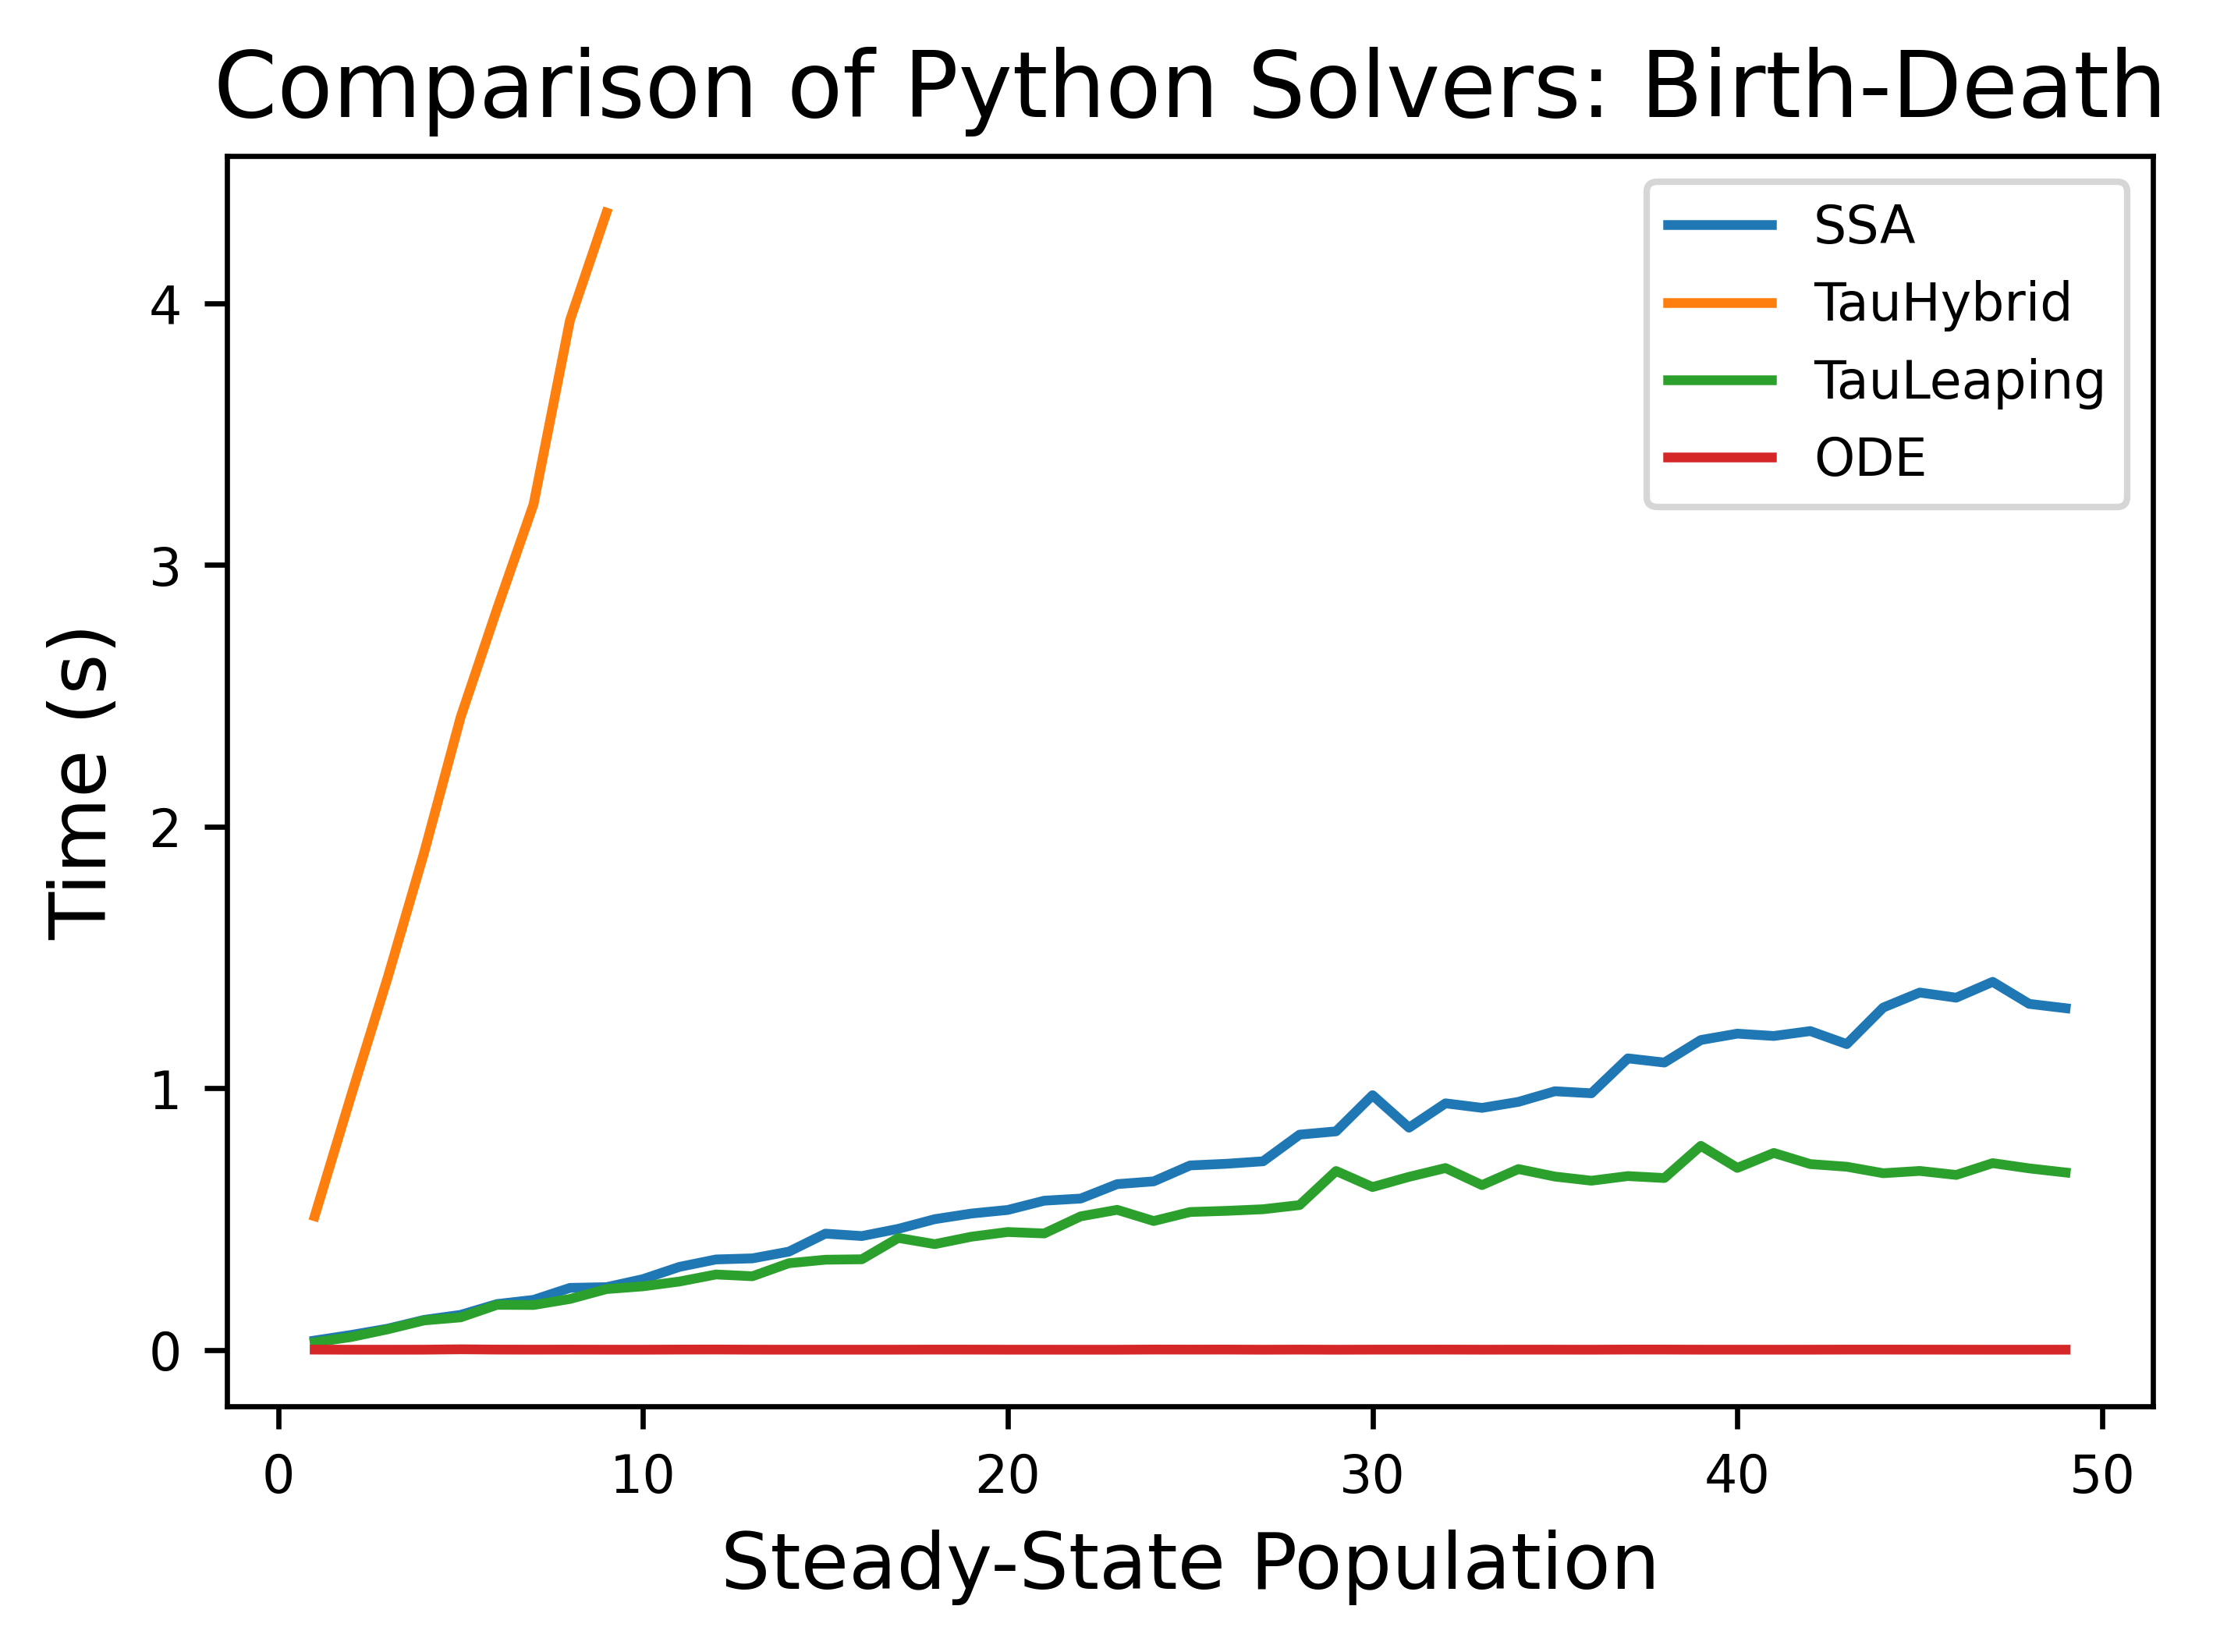

In [19]:
fig = plt.figure(figsize=(5.31,3.54), dpi=600)
for name in Solver_plot_order:
    times = C_solver_timing_data[name]
    name2=name.replace('CSolver','')
    plt.plot(v_range[0:len(NumPy_solvers_timing_data[name])], NumPy_solvers_timing_data[name], label=name2)
plt.title("Comparison of Python Solvers: Birth-Death", fontsize=14)
plt.xlabel('Steady-State Population', fontsize=12)
plt.ylabel('Time (s)', fontsize=12)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(loc='best', fontsize=8)
plt.savefig('../images/Time_Comparison_Of_Python_Solvers.pdf', bbox_inches='tight')

In [20]:
raise Exception('stop')

Exception: stop

### SSA

In [ ]:
%time timing_data['SSA'] = run_test("SSA")

### Tau Leaping

In [ ]:
%time timing_data['tau_leaping'] = run_test("Tau-Leaping")

### Tau Hybrid

In [ ]:
%time timing_data['hybrid_tau'] = run_test("Tau-Hybrid")

***
## Visualizations
***

In [ ]:
plt.figure(figsize=(20,10))
plt.title("Time Comparison of Solvers")
plt.xlabel("initial Value of V (species count)")
plt.ylabel("Simulation Run Time (s)")
plt.plot(v_range, timing_data['SSA'], label='SSA')
plt.plot(v_range, timing_data['tau_leaping'], label='tau_leaping')
plt.plot(v_range, timing_data['hybrid_tau'], label='hybrid_tau')
plt.legend(loc='best')
#plt.savefig("Time_Comparison_Of_Solvers.pdf")